# Key Consideration for Data:
The input vector is currently 3D: (n_samples, t_timesteps, m_notes). n_samples represents the number of rows of in sequence chords/notes. t_timesteps is the number of notes ahead of the ith that note will be contained within a row vector. m_notes is the one hot vector of size representing the number 202 unique notes/chords that were found during parsing and encoding of data. So if sequence length is 16, then a row vector will be: <br/>
[[[one_hot_encoded_chord_1]],[[one_hot_encoded_chord_2]],...[[one_hot_encoded_chord_i+t_timesteps]]]. <br/>
# Important References and Notes:
* Loss Functions
    * https://gombru.github.io/2018/05/23/cross_entropy_loss/
* Using TensorBoard
    * https://github.com/tensorflow/tensorboard/issues/2819
    * https://www.youtube.com/watch?v=YGQqh7mmWb4
* ANN Visualizer Does Not Run
* Keras Blog
    * https://blog.keras.io/building-autoencoders-in-keras.html
* LSTM Auto-Encoder
    * https://machinelearningmastery.com/lstm-autoencoders/
* TF tutorial
    * https://www.datacamp.com/community/tutorials/using-tensorflow-to-compose-music
* On Input Shape and Model Complexity
    * https://towardsdatascience.com/ultimate-guide-to-input-shape-and-model-complexity-in-neural-networks-ae665c728f4b
* Autoencoder Architecture
    * A. Géron, “Chapter 17: Representation Learning and Generative Learning Using Autoencoders and GANs,” in Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: concepts, tools, and techniques to build intelligent systems, 2nd ed., Sebastopol, CA: O'Reilly Media, Inc., 2019, pp. 572–573. 
    * https://medium.com/@venkatakrishna.jonnalagadda/sparse-stacked-and-variational-autoencoder-efe5bfe73b64

# Functions

In [16]:
def get_chords_from_prediction(generated_chord_arr, mapping):
    """Gets predicted chords as string from generated chord probability array.
    
    :param generated_chord: <class 'numpy.ndarray'> of
        probabilities indicating what the predicted chord
        should be.
    :param mapping: <class 'dict'> that maps <class 'int'>
        chord to a <class 'str'> chord.
    :return: <class 'list'> of the 
    """
    # Validate args
    if (not isinstance(generated_chord_arr, np.ndarray)):
        raise TypeError("'generated_chord_arr' must be of type <class 'numpy.ndarray'>" )
    if (len(generated_chord_arr.shape) < 3):
        raise ValueError("'generated_chord_arr' must have at least 3 dimensions (one_sample, t_timesteps, m_chords).")
    if (generated_chord_arr.shape[0] > 1):
        raise ValueError("'generated_chord_arr' should only have a single sample (one_sample, t_timesteps, m_chords).")

    ## Iterate through array and build chord outputs
    output_list = []
    for chord_probability_array in generated_chord_arr[0]:

        # Append to list
        output_list.append(mapping[chord_probability_array.argmax()])

    # Return the converted chords list
    return output_list


def get_chords_from_one_hot_array(one_hot_chord_arr, mapping):
    """Converts one hot vectors to list of strings of chords.
    
    :param one_hot_chord_arr: <class 'numpy.ndarray'> of shape
        (n_samples, t_timesteps, m_chords) where the mth m_chord is 
        a one-hot labeled vector representing a unique chord/note
        combination. n_samples SHOULD BE 1 FOR NOW.
    :param mapping: <class 'dict'> that maps an integer chord/note
        to a corresponding string.
    :return: <class 'list'> of <class 'str'> of converted 
        one-hot vectors to music21 syntax (but not type) chords.
    """

    ## Validation
    # Type checking
    if (not isinstance(one_hot_chord_arr, np.ndarray)):
        raise TypeError("'one_hot_chord_arr' must be of type <class 'numpy.ndarray'>" )

    # Check shape
    if (len(one_hot_chord_arr.shape) != 3):
        raise ValueError("'one_hot_chord_arr' must have a shape of 3: (n_samples, t_timesteps, m_chords)")
    

    ## For each sample in the array
    string_chord_list = []

    ## For each sequence in the sample
    for chord in one_hot_chord_arr[0]:

            # Check the index of arg max
            ix_arg_max = chord.argmax()

            # map that index (int) to chord
            ix_to_chord = mapping[ix_arg_max]

            # Append to row
            string_chord_list.append(ix_to_chord)

    # Return the list in string-chord format
    return string_chord_list


def convert_string_to_chord(concatenated_chord):
    """Convert a concatenated chord to list of notes for music21 chord.
    
    :param concatenated_chord: <class 'str'>  A concatenated string
        representing a string.
    :return: <class 'list'> A list of strings representing a chord
        for music21
    """
    chord = []
    slice_from = 0
    for ix, char in enumerate(concatenated_chord):
        if char.isdigit():
            chord.append(concatenated_chord[slice_from:ix + 1])
            slice_from = ix + 1

    # Return list of notes (a chord)
    return chord


def generate_music21_stream_from_chords(chord_list, instrument_part=None):
    """Convert a list of chords to a music21 stream.
    
    :param chord_list: <class 'list'> of <class 'str'>
        chords to be converted to music21 stream
    :param path_to_write: <class 'str'>
    :param instrument: <class 'music21.instrument.Instrument'> Defaults
        to KeyboardInstrument()
    :return: <class 'music21.stream.Part'>
    """

    # Default instrument
    if (not instrument_part):
        instrument_part = instrument.KeyboardInstrument()

    # Chord list
    print('List of chords to be converted to music21 stream:', chord_list)

    ## Make stream
    # Generate stream with piano as instrument
    generated_stream = stream.Part()
    generated_stream.append(instrument_part)

    # Append notes to stream
    for single_chord in chord_list:
        try:
            generated_stream.append(note.Note(single_chord))
            print('Note:', single_chord )
        except:
            extracted_chord = convert_string_to_chord(single_chord)
            generated_stream.append(chord.Chord(extracted_chord))
            print('String to chord:', single_chord, ' -> ' ,extracted_chord)


    # Return the music21 stream
    return generated_stream

# Begin Code

In [17]:
# TF and Keras
import tensorflow.keras as keras
from keras.callbacks import TensorBoard
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras import backend as K
display('TF Version:', tf.__version__)
display('Keras Version:', keras.__version__)
print(device_lib.list_local_devices())

'TF Version:'

'2.1.0'

'Keras Version:'

'2.2.4-tf'

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15400644887028358348
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3057333044
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7510589318194633119
physical_device_desc: "device: 0, name: GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:57:00.0, compute capability: 7.5"
]


In [18]:
# Other Imports
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
# from ann_visualizer.visualize import ann_viz
from statistics import mode
from sklearn.model_selection import train_test_split
from music21 import *
from datetime import datetime

# Data Loading

In [19]:
%%time

# Load feature and encoding data
path_to_pickled_data = r'..\..\playing_with_data\pickled_data'
with open(os.path.join(path_to_pickled_data, 'pickled_feature_and_encoding_dict'),'rb') as fobj:
    data_dict = pickle.load(fobj)

# Get Data
print(data_dict.keys())
chords_ds = data_dict['reduced_chords_ds']
durations_ds = data_dict['reduced_durations_ds']
chord_to_int = data_dict['chord_to_int']
duration_to_int = data_dict['duration_to_int']
int_to_chord = data_dict['int_to_chord']
int_to_duration = data_dict['int_to_duration']

# Data preprocessing

## Defining training data -- previous sequential data

# The sequence length -- number of consecutive notes/chords along with corresponding duration
sequence_length = 16

# Empty lists for train data
all_chords = []
all_durations = []

## Sequence construction
# The chord_ds encapsulates the chords/notes associated with a particular score index
for score_ix in range(len(chords_ds)):

    # Convert the <class 'str'> chords/notes in the chords_ds for a particular score index
    # to a list of integers. 
    int_chord_list = [chord_to_int[chord] for chord in chords_ds[score_ix]]

    # Do the same for the durations
    int_duration_list = [duration_to_int[duration] for duration in durations_ds[score_ix]]

    ## Build the training sets
    # Loop variable 'i' ranges the len of the integer chord list -- number of chords
    # for a score -- MINUS the desired sequence length
    # Essentially frames a temporally related problem in a supervised learning manner 
    # by making an input vector contain the i through i + sequence length notes.
    # For example, if sequence length is 8... then if an input vector is composed of 
    # chords and subsequent chords N time steps (or sequence length) in the future, 
    # the chords/notes 0 through 8 will be acquired... then 1 through 9... etc.
    # The range of a given list of chords is reduced by sequence length to avoid
    # out of range indexing.
    for i in range(len(int_chord_list) - sequence_length):
        all_chords.append(int_chord_list[i: i + sequence_length])
        all_durations.append(int_duration_list[i: i + sequence_length])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    all_chords,
    all_chords, 
    random_state=42, 
    test_size=0.3,
    shuffle=False
)

## One-hot encode data
# ... I don't transpose here as it would make
# all one hot vectors zeroes.
# Refer to docs here, but the logic is that each column in a given row represents a single chord/note
# There are only 202 unique chords/notes in this data set. This is from the parsing and encoding of the data.
# The to_categorical function looks determines that there are only 202 unique column values (categories or chords).
# Therefore, each chord/note can be represented by a one-hot array of length 202
one_hot_train_chords_array = keras.utils.to_categorical(X_train, num_classes=202)
one_hot_test_chords_array = keras.utils.to_categorical(X_test, num_classes=202)

# (?, t_timesteps, m_chords) for 
n_samples = one_hot_train_chords_array.shape[0]
m_chords = len(one_hot_train_chords_array[0][0])  # Number of one hot digits
t_timesteps = sequence_length or one_hot_train_chords_array.shape[1]

# Check number of chords/notes in each chord sublist
print([len(sublist) for sublist in chords_ds])

## Inspect data dimensions
print()
print('Decription of dimensions of one hot labeled training data:')
print('N samples:', n_samples)
print('Number of time steps:', t_timesteps)
print('Length of one-hot array for encoded chord (number of chords):', m_chords)
print() 

# Log the time
log_now = datetime.now().strftime("%Y%m%d/%H:%M:%S").replace(':', '-').replace('/', '_')
print(type(log_now))
print('Data loaded at:', log_now)

dict_keys(['reduced_chords_ds', 'reduced_durations_ds', 'chord_to_int', 'duration_to_int', 'int_to_chord', 'int_to_duration'])
[68, 103, 40, 32, 92, 121, 93, 80, 123, 42, 93, 32, 74, 108, 50, 98]

Decription of dimensions of one hot labeled training data:
N samples: 695
Number of time steps: 16
Length of one-hot array for encoded chord (number of chords): 202

<class 'str'>
Data loaded at: 20210422_15-34-56
Wall time: 11 ms


# Training Data and Inspection of Encoded Data Set

In [20]:
## Find most common occur chord in unlabeled array
# Flatten it and find the most commonly occurring chord
flattened_chord_list = [chord for sequence in X_train for chord in sequence]
most_common_chord = mode(flattened_chord_list)
max_chord = max(flattened_chord_list)
min_chord = min(flattened_chord_list)
print('The most commonly occurring chord/note is integer:', most_common_chord, ' or ', int_to_chord[most_common_chord])
print('The max chord is:', max_chord)
print('The min chord is:', min_chord)

The most commonly occurring chord/note is integer: 172  or  F#2
The max chord is: 201
The min chord is: 0


# Autoencoders

In [21]:
# Relevant input dimensions for the encoder and decoder
latent_dim = 2
hidden_units_one = 64

# Combined Sequential Autoencoder -- Encoder and Decoder Are Not Separate for Save/Load Purposes

In [22]:
# Build the autoencoder as a sequential network only to see if saving/loading works then
sequential_autoencoder = keras.models.Sequential([
    
    # Input 
    keras.layers.Input(shape=(t_timesteps, m_chords), name='encoder_input'),
    
    ## Begin encoder
    # Encoder hidden
    keras.layers.Dense(hidden_units_one, activation='tanh', name='encoder_hidden_layer1'),
    
    ## Latent layer
    keras.layers.Dense(latent_dim, activation='tanh', name='latent'),

    ## Decoder
    # Decoder hidden
    keras.layers.Dense(hidden_units_one, activation='tanh', name='decoder_hidden_layer1'),
    
    # Output layer
    keras.layers.Dense(m_chords, activation='sigmoid', name='decoder_output')
],
name='autoencoder')

In [23]:
# Compile the model
sequential_autoencoder.compile(
    loss='binary_crossentropy', 
    optimizer='rmsprop',  # Could use Adam instead?
    metrics=[keras.metrics.BinaryCrossentropy()]
)

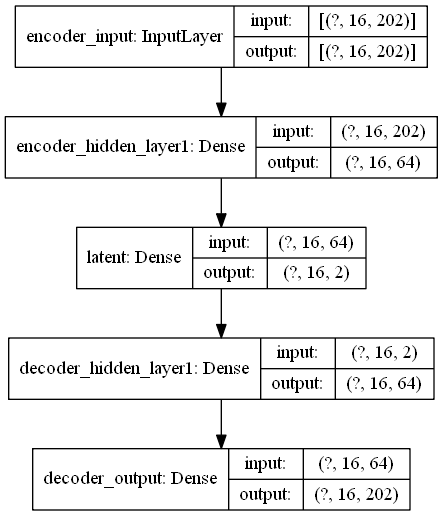

In [24]:
# Plot the sequential autoencoder
keras.utils.plot_model(
    sequential_autoencoder, 
    to_file='./figures/sequential_autoencoder.png',
    show_shapes=True,
    expand_nested=True
)

In [25]:
# Fit the sequential autoencoder model
fit_model_sequential_autoencoder = True
if (fit_model_sequential_autoencoder):
    history = sequential_autoencoder.fit(
        one_hot_train_chords_array, 
        one_hot_train_chords_array, 
        epochs=128,
        verbose=1,
        validation_data=[one_hot_test_chords_array, one_hot_test_chords_array]
        # callbacks=[
        #     TensorBoard(
        #         log_dir='logs\\model', 
        #         histogram_freq=1, 
        #         profile_batch=100000000
        #     ), 
        # ]   
    )

binary_crossentropy: 0.0235 - val_loss: 0.0314 - val_binary_crossentropy: 0.0314
Epoch 12/128
695/695 [==============================] - 0s 201us/sample - loss: 0.0233 - binary_crossentropy: 0.0233 - val_loss: 0.0335 - val_binary_crossentropy: 0.0335
Epoch 13/128
695/695 [==============================] - 0s 191us/sample - loss: 0.0231 - binary_crossentropy: 0.0231 - val_loss: 0.0347 - val_binary_crossentropy: 0.0347
Epoch 14/128
695/695 [==============================] - 0s 190us/sample - loss: 0.0229 - binary_crossentropy: 0.0229 - val_loss: 0.0349 - val_binary_crossentropy: 0.0349
Epoch 15/128
695/695 [==============================] - 0s 201us/sample - loss: 0.0227 - binary_crossentropy: 0.0227 - val_loss: 0.0354 - val_binary_crossentropy: 0.0354
Epoch 16/128
695/695 [==============================] - 0s 190us/sample - loss: 0.0225 - binary_crossentropy: 0.0225 - val_loss: 0.0357 - val_binary_crossentropy: 0.0357
Epoch 17/128
695/695 [==============================] - 0s 191us/samp

# Save the Model

In [74]:
# Save the sequential model
sequential_model_path = f'./{log_now}_sequential_autoencoder'
save_sequential_model = True
if (save_sequential_model):
    os.mkdir(sequential_model_path)
    sequential_autoencoder.save(sequential_model_path)

INFO:tensorflow:Assets written to: ./20210422_12-03-55_sequential_autoencoder\assets


# History and Learning Curves

dict_keys(['loss', 'binary_crossentropy', 'val_loss', 'val_binary_crossentropy'])
ipykernel_launcher:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


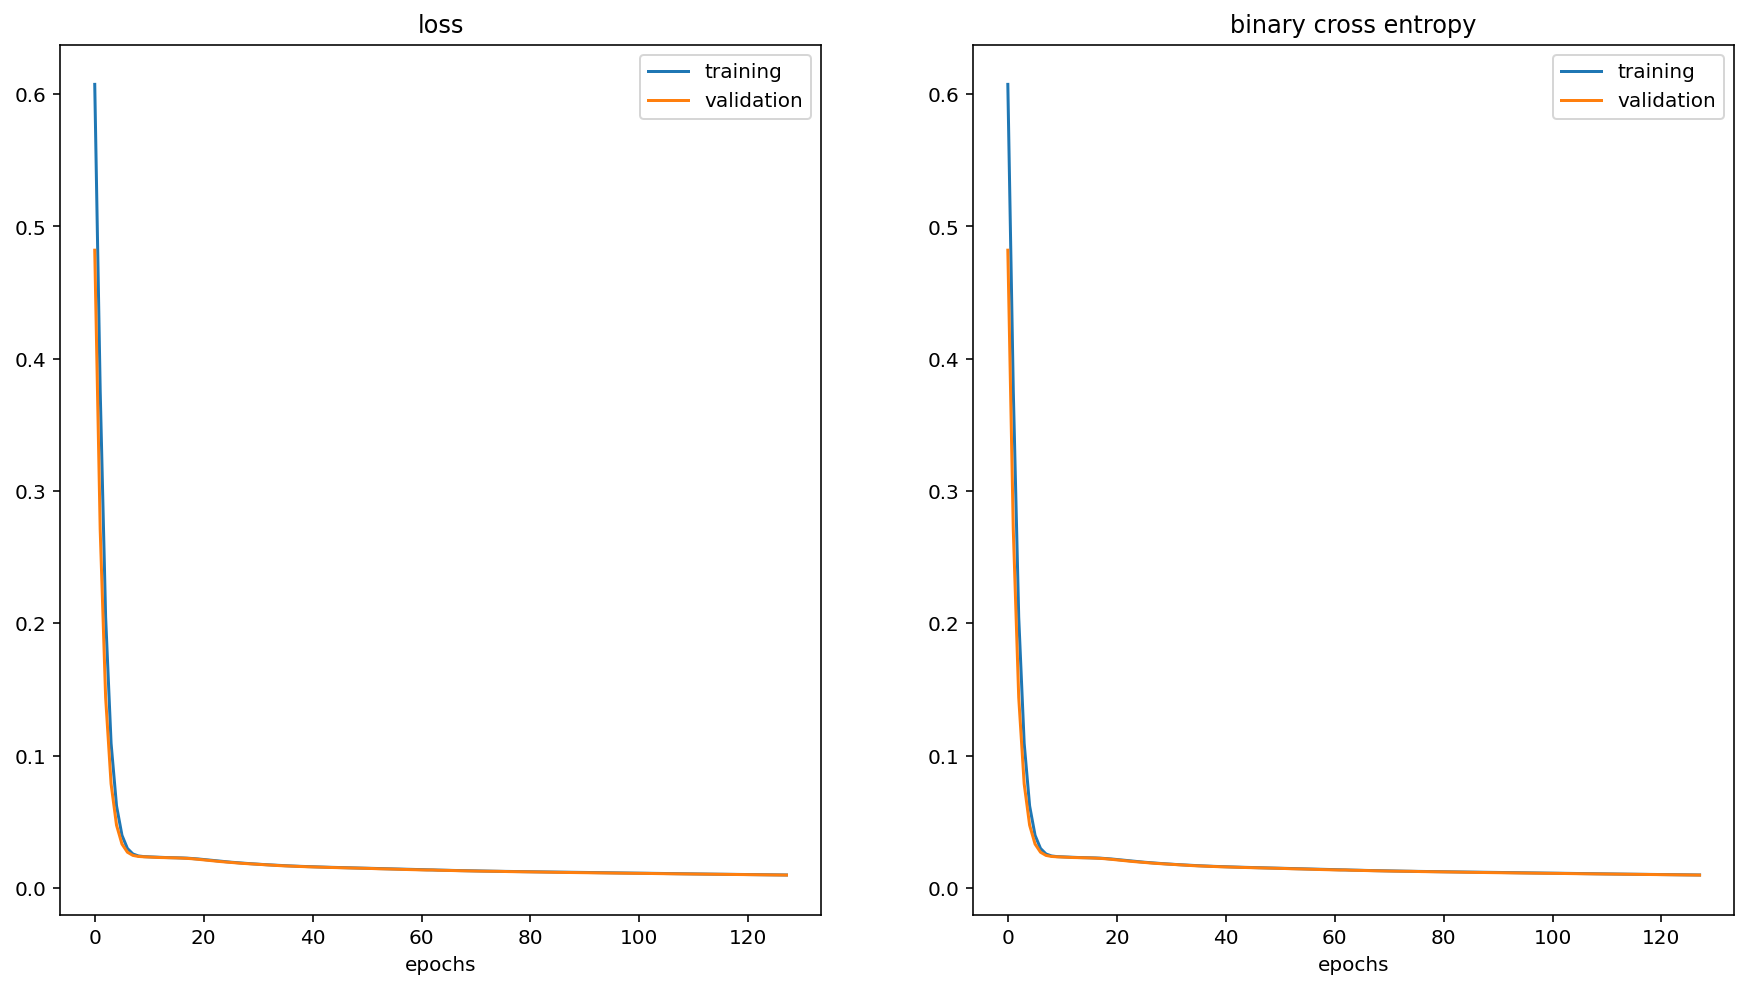

In [75]:
# Plot learning curve
fit_model = True
if (fit_model):

    # Inspect history keys
    print(history.history.keys())

    # Plot the figure
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
    axs[0].plot(history.history['loss'], label='training')
    axs[0].plot(history.history['val_loss'], label='validation')
    axs[1].plot(history.history['binary_crossentropy'], label='training')
    axs[1].plot(history.history['val_binary_crossentropy'], label='validation')


    # Label it
    axs[0].set_title('loss')
    axs[0].set_xlabel('epochs')
    axs[1].set_title('Categorical Cross Entropy')
    axs[1].set_xlabel('epochs') 

    # Legend
    axs[0].legend()
    axs[1].legend()

    # Show
    fig.show()

In [76]:
# # What is the expected input of the decoder?
# # (?, t_time_steps, latent_dim)
# # Clearly this output is not ideal as it is generating notes in a very odd range
# decoder_generated_chords = decoder_model(np.random.normal(size=(1, t_timesteps, latent_dim))).numpy()

# print(max(decoder_generated_chords[0][0]))

# # Check maxes of each
# # [arr for arr in decoder_generated_chords if max(arr) != 0]

In [77]:
## Random input for model prediction

# # Random integer array
# random_input = np.random.randint(m_chords, size=t_timesteps)
# print('Random integer array input:', random_input)

# # One-hot label that array
# random_input_one_hot = tf.keras.utils.to_categorical(random_input, num_classes=m_chords)
# random_input_one_hot = random_input_one_hot.reshape(1, t_timesteps, m_chords)
# print('One-hot labeled random array dims:', random_input_one_hot.shape)

# Predicting Chords

In [78]:
# Load most recent model
load_recent_stacked_autoencoder = True
load_recent_stacked_autoencoder_path = f'./{log_now}_sequential_autoencoder'
if (load_recent_stacked_autoencoder):
    stacked_autoencoder = keras.models.load_model(load_recent_stacked_autoencoder_path)

# Load a model manually
load_manual = False
manual_model_path = '20210422_11-14-01_sequential_autoencoder'
if (load_manual):

    # Specifiy model path here
    stacked_autoencoder = keras.models.load_model(manual_model_path)


In [79]:
# Take an arbitary sequence of notes from the the Nth sequence of 16 notes in the test array
test_input = one_hot_test_chords_array[150, :].reshape(1, t_timesteps, m_chords)
test_song = get_chords_from_one_hot_array(test_input, mapping=int_to_chord)
display(test_song)

# Use the model to predict chords
generated_chords = stacked_autoencoder.predict(
    test_input
)

# Get the chord integers from the prediction
generated_song = get_chords_from_prediction(generated_chords, mapping=int_to_chord)
display(generated_song)

['G3G4',
 'G3C4',
 'G3D4',
 'G3E4',
 'A3E4',
 'A3F4',
 'B-3G4',
 'B-3E-4',
 'A3F4',
 'G3G4',
 'F3F4',
 'F3B-3',
 'D3B-3',
 'C#3B-3',
 'E3C#4',
 'G3E4']

['G3G4',
 'G3D4',
 'G3D4',
 'B-3',
 'D2E-3',
 'G3G4',
 'G3D4',
 'D2G5',
 'G3G4',
 'G3G4',
 'G3G4',
 'D2G5',
 'B-3',
 'D2G5',
 'G3D4',
 'B-3']

# Create MIDI file for the generated song as well as the song that it was derived from -- this way they can be compared...

In [80]:
# Generate stream with piano as instrument
generated_stream = generate_music21_stream_from_chords(generated_song)

# Test stream with piano as instrument
print()
test_stream = generate_music21_stream_from_chords(test_song)

List of chords to be converted to music21 stream: ['G3G4', 'G3D4', 'G3D4', 'B-3', 'D2E-3', 'G3G4', 'G3D4', 'D2G5', 'G3G4', 'G3G4', 'G3G4', 'D2G5', 'B-3', 'D2G5', 'G3D4', 'B-3']
String to chord: G3G4  ->  ['G3', 'G4']
String to chord: G3D4  ->  ['G3', 'D4']
String to chord: G3D4  ->  ['G3', 'D4']
Note: B-3
String to chord: D2E-3  ->  ['D2', 'E-3']
String to chord: G3G4  ->  ['G3', 'G4']
String to chord: G3D4  ->  ['G3', 'D4']
String to chord: D2G5  ->  ['D2', 'G5']
String to chord: G3G4  ->  ['G3', 'G4']
String to chord: G3G4  ->  ['G3', 'G4']
String to chord: G3G4  ->  ['G3', 'G4']
String to chord: D2G5  ->  ['D2', 'G5']
Note: B-3
String to chord: D2G5  ->  ['D2', 'G5']
String to chord: G3D4  ->  ['G3', 'D4']
Note: B-3

List of chords to be converted to music21 stream: ['G3G4', 'G3C4', 'G3D4', 'G3E4', 'A3E4', 'A3F4', 'B-3G4', 'B-3E-4', 'A3F4', 'G3G4', 'F3F4', 'F3B-3', 'D3B-3', 'C#3B-3', 'E3C#4', 'G3E4']
String to chord: G3G4  ->  ['G3', 'G4']
String to chord: G3C4  ->  ['G3', 'C4']
Str

In [81]:
# Write the generated stream
generated_stream.write('midi', f'./generated_songs/{log_now}_generated_song.mid')

# Write test stream
test_stream.write('midi', f'./generated_songs/{log_now}_test_song.mid') 

'./generated_songs/20210422_12-03-55_test_song.mid'

In [62]:
# Write the 

<class 'music21.stream.Part'>


# Conclusions
Generation is fine for now. Try feeding it other songs in the key of bminor outside of this data set to see what it produces. Often single note melodies will be produced only. Autoencoder could be memorizing and not learning latent representations which may lead to overfitting and perform generalization on other songs.